In [1]:
print("Hello World")

Hello World


# Download a sample dataset

In [29]:
from pathlib import Path

cwd = Path.cwd()
data_path = cwd / "Dry_Bean_Dataset.xlsx"

In [30]:
import pandas as pd

beans = pd.read_excel(data_path)
beans.to_csv(cwd / "dry_bean.csv", index=False)

# Setting up the notebook instance for SageMaker

In [31]:
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

In [32]:
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()

In [33]:
region = sess.boto_session.region_name
BUCKET_URI = "s3://bean-bucket-test"
BUCKET_NAME = "bean-bucket-test"
DATASET_PATH = f"{BUCKET_URI}/dry_bean.csv"
TARGET_NAME = "Class"

# Loading data from an S3 bucket into SageMaker

In [34]:
dry_bean = pd.read_csv(DATASET_PATH)
dry_bean.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


# Performing EDA in SageMaker

In [35]:
dry_bean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

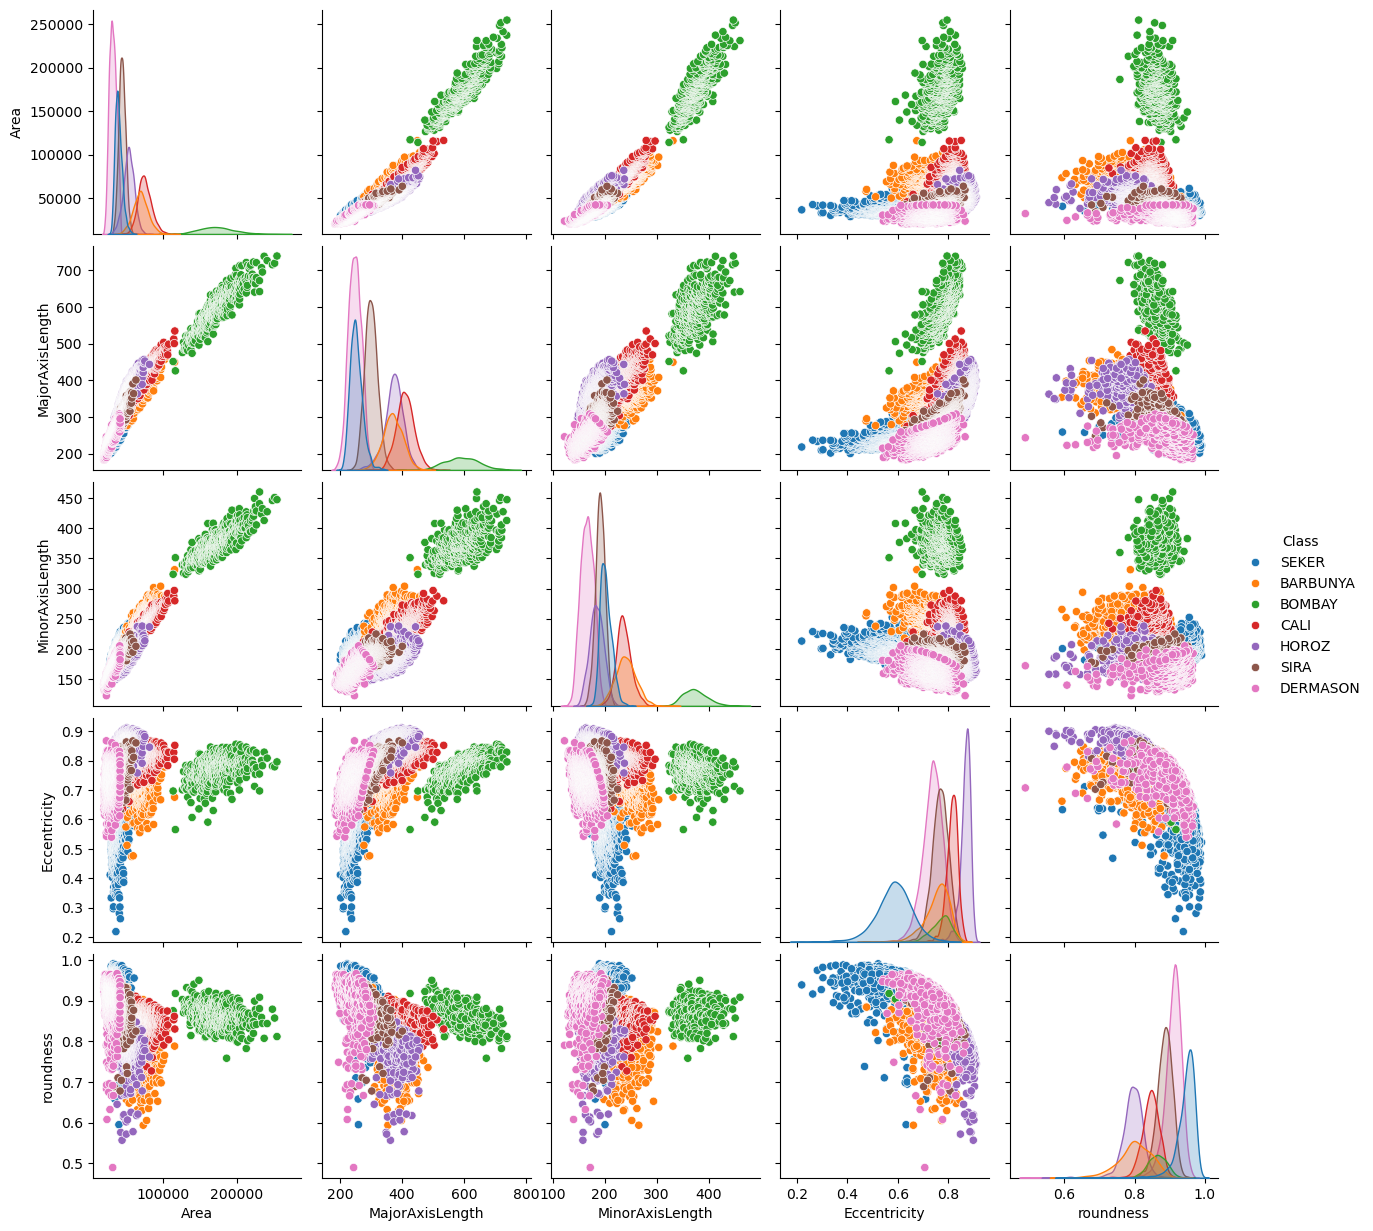

In [36]:
import seaborn as sns

sns.pairplot(
   dry_bean,
   vars=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "roundness"],
   hue="Class",
);

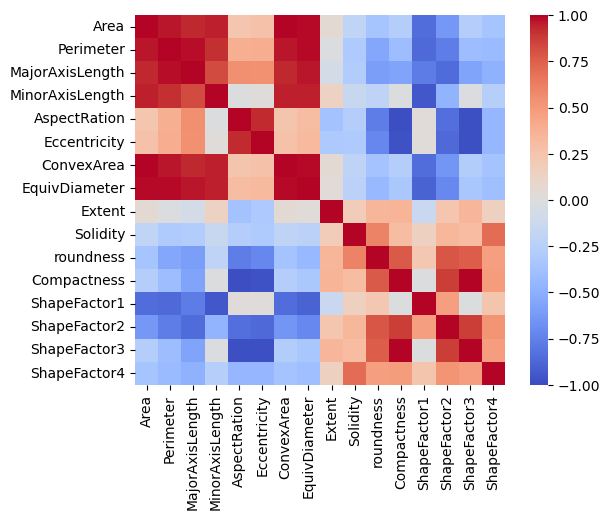

In [37]:
import matplotlib.pyplot as plt

correlation = dry_bean.corr(numeric_only=True)

# Create a square heatmap with center at 0
sns.heatmap(correlation, center=0, square=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

# Preparing data for model training in SageMaker

In [38]:
from sklearn.preprocessing import LabelEncoder

# For preprocessing
df = dry_bean.copy(deep=True)

# Encode the target
le = LabelEncoder()
df[TARGET_NAME] = le.fit_transform(df[TARGET_NAME])

In [39]:
from sklearn.model_selection import train_test_split

# Split the data into two sets
train, test = train_test_split(df, random_state=1, test_size=0.2)

In [40]:
train.to_csv("dry-bean-train.csv")
test.to_csv("dry-bean-test.csv")

In [41]:
# Send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
   path="dry-bean-train.csv",
   bucket=BUCKET_NAME,
   key_prefix="sagemaker/sklearncontainer",
)

testpath = sess.upload_data(
   path="dry-bean-test.csv",
   bucket=BUCKET_NAME,
   key_prefix="sagemaker/sklearncontainer",
)

# Writing a training script for SageMaker

In [43]:
%%writefile script.py

import argparse
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

if __name__ == "__main__":
   print("extracting arguments")
   parser = argparse.ArgumentParser()

   # Hyperparameters sent by the client are passed as command-line arguments to the script.
   parser.add_argument("--n-estimators", type=int, default=10)
   parser.add_argument("--min-samples-leaf", type=int, default=3)

   # Data, model, and output directories
   parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
   parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
   parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
   parser.add_argument("--train-file", type=str, default="dry-bean-train.csv")
   parser.add_argument("--test-file", type=str, default="dry-bean-test.csv")
   args, _ = parser.parse_known_args()
   
   print("reading data")

   train_df = pd.read_csv(os.path.join(args.train, args.train_file))
   test_df = pd.read_csv(os.path.join(args.test, args.test_file))

   print("building training and testing datasets")

   X_train = train_df.drop("Class", axis=1)
   X_test = test_df.drop("Class", axis=1)
   y_train = train_df[["Class"]]
   y_test = test_df[["Class"]]

   # Train model
   print("training model")

   model = RandomForestClassifier(
       n_estimators=args.n_estimators,
       min_samples_leaf=args.min_samples_leaf,
       n_jobs=-1,
   )

   model.fit(X_train, y_train)

   # Print abs error
   print("validating model")

   bal_acc_train = balanced_accuracy_score(y_train, model.predict(X_train))
   bal_acc_test = balanced_accuracy_score(y_test, model.predict(X_test))

   print(f"Train balanced accuracy: {bal_acc_train:.3f}")
   print(f"Test balanced accuracy: {bal_acc_test:.3f}")

   # Persist model
   path = os.path.join(args.model_dir, "model.joblib")
   joblib.dump(model, path)
   print("model persisted at " + path)

Overwriting script.py


In [45]:
!python script.py --n-estimators 100 --min-samples-leaf 2 --model-dir ./ --train ./ --test ./

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.sparse import csr_matrix, issparse
extracting arguments
reading data
building training and testing datasets
training model
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
validating model
Train balanced accuracy: 1.000
Test balanced accuracy: 0.997
model persisted at ./model.joblib


# Creating a custom training job in SageMaker

In [46]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn
FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
   entry_point="script.py",
   role=get_execution_role(),
   instance_count=1,
   instance_type="ml.c5.xlarge",
   framework_version=FRAMEWORK_VERSION,
   base_job_name="rf-scikit",
   hyperparameters={
       "n-estimators": 100,
       "min-samples-leaf": 3,
   },
)

In [47]:
# Launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: rf-scikit-2024-10-08-18-27-13-482


2024-10-08 18:27:16 Starting - Starting the training job...
2024-10-08 18:27:31 Starting - Preparing the instances for training...
2024-10-08 18:28:03 Downloading - Downloading input data...
2024-10-08 18:28:48 Training - Training image download completed. Training in progress...2024-10-08 18:28:52,786 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-08 18:28:52,789 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:28:52,825 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-08 18:28:52,982 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:28:52,993 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:28:53,003 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:28:53,010 sagemaker-training-toolkit INFO     Invoking user script


# Using Spot Instances during training to reduce costs

In [48]:
spot_sklearn_estimator = SKLearn(
   entry_point="script.py",
   role=get_execution_role(),
   instance_count=1,
   instance_type="ml.c5.xlarge",
   framework_version=FRAMEWORK_VERSION,
   base_job_name="rf-scikit",
   hyperparameters={
       "n-estimators": 100,
       "min-samples-leaf": 3,
   },
   use_spot_instances=True,
   max_wait=7200,
   max_run=3600,
)

In [49]:
# Launch training job, with asynchronous call
spot_sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: rf-scikit-2024-10-08-18-30-31-948


2024-10-08 18:30:34 Starting - Starting the training job...
2024-10-08 18:30:47 Starting - Preparing the instances for training...
2024-10-08 18:31:15 Downloading - Downloading input data...
2024-10-08 18:32:01 Training - Training image download completed. Training in progress..2024-10-08 18:32:06,550 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-08 18:32:06,554 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:32:06,601 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-08 18:32:06,747 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:32:06,759 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:32:06,771 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-08 18:32:06,779 sagemaker-training-toolkit INFO     Invoking user script
T

# Hyperparameter tuning using SageMaker

In [50]:
from sagemaker.tuner import IntegerParameter

In [51]:
# We use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
   "n-estimators": IntegerParameter(20, 100),
   "min-samples-leaf": IntegerParameter(2, 6),
}

In [52]:
# Create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
   estimator=sklearn_estimator,
   hyperparameter_ranges=hyperparameter_ranges,
   base_tuning_job_name="RF-tuner",
   objective_type="Maximize",
   objective_metric_name="balanced-accuracy",
   metric_definitions=[
       {"Name": "balanced-accuracy", "Regex": "Test balanced accuracy: ([0-9.]+).*$"}
   ],  # Extract tracked metric from logs with regexp
   max_jobs=10,
   max_parallel_jobs=2,
)

In [56]:
# Start tuning job
Optimizer.fit({"train": trainpath, "test": testpath})

INFO:sagemaker:Creating hyperparameter tuning job with name: RF-tuner-241008-1844


............................................................!


In [58]:
# Get tuner results in a df
results = Optimizer.analytics().dataframe()

while results.empty:
   time.sleep(1)
   results = Optimizer.analytics().dataframe()

results.head()

,min-samples-leaf,n-estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,6.0,35.0,RF-tuner-241008-1844-010-0ee2f1ec,Completed,0.997,2024-10-08 18:49:08+00:00,2024-10-08 18:49:37+00:00,29.0
1,2.0,62.0,RF-tuner-241008-1844-009-e5b3e888,Completed,0.998,2024-10-08 18:49:07+00:00,2024-10-08 18:49:36+00:00,29.0
2,6.0,21.0,RF-tuner-241008-1844-008-6c82aaa3,Completed,0.998,2024-10-08 18:48:22+00:00,2024-10-08 18:48:51+00:00,29.0
3,4.0,69.0,RF-tuner-241008-1844-007-19fb8810,Completed,0.998,2024-10-08 18:48:21+00:00,2024-10-08 18:48:49+00:00,28.0
4,5.0,38.0,RF-tuner-241008-1844-006-b1d021d5,Completed,0.995,2024-10-08 18:47:37+00:00,2024-10-08 18:48:05+00:00,28.0


In [59]:
best_estimator = Optimizer.best_estimator()


2024-10-08 18:49:39 Starting - Found matching resource for reuse
2024-10-08 18:49:39 Downloading - Downloading the training image
2024-10-08 18:49:39 Training - Training image download completed. Training in progress.
2024-10-08 18:49:39 Uploading - Uploading generated training model
2024-10-08 18:49:39 Completed - Resource retained for reuse


# Deploying models to endpoints in SageMaker 

In [61]:
artifact_path = sm_boto3.describe_training_job(
   TrainingJobName=best_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact_path)

Model artifact persisted at s3://sagemaker-us-east-1-058264416104/RF-tuner-241008-1844-009-e5b3e888/output/model.tar.gz


In [62]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
   model_data=artifact_path,
   role=get_execution_role(),
   entry_point="script.py",
   framework_version=FRAMEWORK_VERSION,
)

In [ ]:
# Deploy the model to a SageMaker endpoint
predictor = model.deploy(
    instance_type="ml.c5.large",  # Choose instance type based on your needs
    initial_instance_count=1      # Number of instances
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-10-08-19-22-04-903
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-10-08-19-22-05-578
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-10-08-19-22-05-578


---------------------

In [ ]:
preds = predictor.predict(test.sample(4).drop("Class", axis=1))
preds

Once you are done using it, don’t forget to delete the endpoint, as it constantly incurs new costs:

In [ ]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)